In [1]:
#   Importing all the necessary libraries/modules.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import skimage.io as io
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES=True    #   To avoid errors while loading truncated images.
from PIL import Image
import re
import pytesseract
import pickle

##### **References:**

- Gong, D. (2022, July 12). *Top 6 Machine Learning Algorithms for Classification.* Medium. https://towardsdatascience.com/top-machine-learning-algorithms-for-classification-2197870ff501
- V, N. (2022, March 15). *Image Classification using Machine Learning.* Analytics Vidhya. https://www.analyticsvidhya.com/blog/2022/01/image-classification-using-machine-learning/
- Anand, A. (2020, June 22). *Basic Machine Learning Cheatsheet using Python [10 Classification & Regression Methods].* DEV Community 👩‍💻👨‍💻. https://dev.to/amananandrai/basic-machine-learning-cheatsheet-using-python-10-classification-regression-methods-9g0
- *1.12. Multiclass and multioutput algorithms.* (n.d.). Scikit-learn. https://scikit-learn.org/stable/modules/multiclass.html
- EliteDataScience. (2022, July 6). *How to Handle Imbalanced Classes in Machine Learning.* https://elitedatascience.com/imbalanced-classes

## **Classification:**

Classification is defined as the process of recognition, understanding, and grouping of objects and ideas into preset categories (classes). With the help of these pre-categorised training datasets, classification in machine learning programs leverage a wide range of algorithms to classify future datasets into respective and relevant categories (classes). Classification algorithms used in machine learning utilize input training data for the purpose of predicting the likelihood or probability that the data that follows will fall into one of the pre-determined categories.

One of the most common applications of classification algorithms is image and text classification to determine which pre-determined categories certain image and/or text data is the most relevant to. While classification algorithms work for a variety of image and text data, I've trained certain image and text classification models specifically for the classification of internet memes to determine whether a certain meme relays one of five pre-categorised sentiments; neutral, positive, negative, very positive, and very negative. The training dataset used for the image and text classification models consists of image data from **6,992** different internet memes along with their respective sentiments based on the text data extracted from each of them.

**Source (Dataset):** https://drive.google.com/file/d/1J1SknxcjbjuK0I3OksEleQ7nF53cxdWS/view?usp=share_link

### **‣   Image Classification:**

Firstly, I'm going to be training and testing three noteworthy machine learning classification models for image classification, namely Random Forest Classifier, K-Nearest Neighbours Classifier, and Extra Trees Classifier, against the training and testing sets for the images (memes) to find the most accurate one, which will then be used for testing against a custom image (meme) to see if the predicted result is correct or not.

##### **•   Reading the data:**

First of all, I've read the data given in the CSV (.csv) file, which contains the extracted text (corrected) from each image along with its sentiment, and stored it in a pandas.DataFrame. I've assigned numerical values to each of the sentiments corresponding to the images, ranging from '0' for a sentiment of "neutral" to '4' for a sentiment of "very_negative", since scikit-learn expects only numerical values, and ordered them in ascending order.

In [2]:
dataframe=pd.read_csv("labels.csv") #   Reading the data from the specified CSV (.csv) file.
dataframe=dataframe.drop(dataframe.columns[0], axis=1)  #   Dropping the first column of the dataframe.
dataframe["overall_sentiment"]=dataframe["overall_sentiment"].map({"neutral":0, "positive":1, "very_positive":2, "negative":3, "very_negative":4})    #   Assigning numerical values to the image sentiments.
dataframe=dataframe.sort_values(by=["overall_sentiment"], ascending=True)
dataframe=dataframe.reset_index(drop=True)  #   Resetting the index of the pandas.DataFrame.
dataframe

,image_name,text_ocr,text_corrected,overall_sentiment
0,image_1311.jpg,THAT MOMENT YOU REALIZE USE THIS WAS A REALLY ...,THAT MOMENT YOU REALIZE USE THIS WAS A REALLY ...,0
1,image_1664.jpg,THE FACE YOU MAKE WHEN YOU MEET HER EX PUUSLIW...,THE FACE YOU MAKE WHEN YOU MEET HER EX PUUSLIW...,0
2,image_5509.jpg,Me in 2011 small issues offhandedly dismissed ...,Me in 2011 small issues offhandedly dismissed ...,0
3,image_1666.jpg,WEALTHY KNIGHT THAT COULD HAVE ANY WOMAN? FUCK...,WEALTHY KNIGHT THAT COULD HAVE ANY WOMAN? FUCK...,0
4,image_1669.jpg,WHAT YOU THINK YOU LOOK LIKE FLIRTING WITH YOU...,WHAT YOU THINK YOU LOOK LIKE FLIRTING WITH YOU...,0
...,...,...,...,...
6987,image_4076.jpg,YOU GET TO EAT FOOD EVERYDAY?! quickmeme.com,YOU GET TO EAT FOOD EVERYDAY?! quickmeme.com,4
6988,image_5871.jpg,"DATHI WHAT IS WITH ""HER NECK ANYWAY? imgflip.com","DATHI WHAT IS WITH ""HER NECK ANYWAY? imgflip.com",4
6989,image_3622.jpg,DONT TREAT WOMEN LIKE OBJECTS OBJECTS ARE USEF...,DONT TREAT WOMEN LIKE OBJECTS OBJECTS ARE USEF...,4
6990,image_5451.jpeg,THIS IS THE I'M WHITE,"THIS IS THE I'M WHITE BUT MY KIDS WONT BE""HAIRDO",4


##### **•   Determining if there's an imbalance between classes:**

Imbalanced classes are one of the most common problems in machine learning, which make the machine learning classification models significantly inaccurate. Imbalacing occurs in datasets with a disproportionate ratio of observations in each class. Standard accuracy no longer reliably measures performance, which makes training machine learning classification models much more complicated.

As can be observed from the graph of the counts of the image sentiments, there's a severe imbalance between the classes, which also affects the accuracy of the machine learning classification models. Before any further pre-processing is applied, the first thing to do is to balance the classes, which will eventually improve the performance of the machine learning classification models, too.

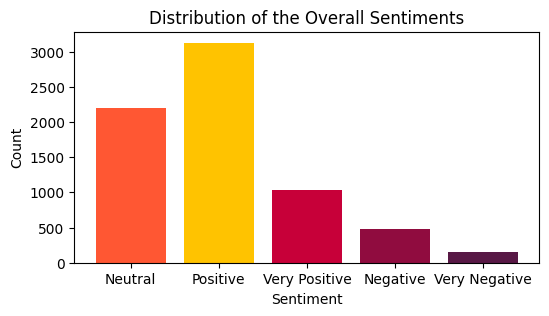

In [3]:
dataframe["overall_sentiment"].value_counts()   #   Finding the count of each sentiment in the pandas.DataFrame.

#   Plotting the distribution of the image sentiments.

plt.figure(figsize=(6, 3))
plt.bar(dataframe["overall_sentiment"].value_counts().index, dataframe["overall_sentiment"].value_counts().values, color=["#FFC300", "#FF5733", "#C70039", "#900C3F", "#581845"])
plt.xticks(dataframe["overall_sentiment"].value_counts().index, ["Positive", "Neutral", "Very Positive", "Negative", "Very Negative"])
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Distribution of the Overall Sentiments")
plt.show()

##### **•   Balancing the imbalanced classes:**

For this, I've used a common balancing method called up-sampling, which is the process of randomly duplicating observations from the minority class in order to reinforce its signal. There are several heuristics for doing so, but the most common way is to simply resample with replacement, for which I've used the sklearn.utils.resample function.

Firstly, I've separated the observations from each class into separate pandas.DataFrame; the majority class, which was the "positive" sentiment is separated into one pandas.DataFrame, and the rest of the classes are separated into another pandas.DataFrame. This allows for binary classification, whereby one class represents the majority and the others concatenate to form the minority. After that, I've resampled the minority class with replacement, setting the number of samples to match that of the majority class. Lastly, I've combined the up-sampled minority class pandas.DataFrame with the the previously separated majority class pandas.DataFrame, and sorted it based on order of the image sentiments (ascending).

As can be observed from the frequencies of the majority class and the combination of the minority classes, the classes are now balanced.

In [4]:
#   Separating the majority and minority classes.

dataframe_majority=dataframe[dataframe["overall_sentiment"]==1]
dataframe_minority=dataframe[dataframe["overall_sentiment"]!=1]

dataframe_minority_upsampled=resample(dataframe_minority, replace=True, n_samples=len(dataframe_majority), random_state=42) #   Resampling the minority class with replacement.
dataframe_upsampled=pd.concat([dataframe_majority, dataframe_minority_upsampled])   #   Concatenating the majority and minority class pandas.DataFrames.
dataframe_upsampled=dataframe_upsampled.sort_values(by=["overall_sentiment"], ascending=True)   #   Sorting the pandas.DataFrame by the overall sentiment.
dataframe_upsampled=dataframe_upsampled.reset_index(drop=True)  #   Resetting the index of the pandas.DataFrame.
dataframe_upsampled["overall_sentiment"].value_counts() #   Finding the frequencies of each sentiment in the pandas.DataFrame.

1    3127
0    1784
2     837
3     398
4     108
Name: overall_sentiment, dtype: int64

##### **•   Extracting the images from the specified directory in order of their sentiments:**

Given in the specified directory is a collection of images (memes) that need to be read individually for their image data. The scikit-image module accomplishes this with the skimage.io.imread function. Furthermore, since the images are ordered according to their corresponding sentiments, I've used the up-sampled pandas.DataFrame containing the image information to pass the ordered file names of the images to be read by the skimage.io.imread function and stored in a list for pre-processing.

In [5]:
#   Extracting the images from the specified directory in order of their sentiments, and storing them in a list.

images=[]
for i in range(len(dataframe_upsampled)):
    image=io.imread("images/"+dataframe_upsampled["image_name"][i])
    images.append(image)

c:\Users\huzai\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


##### **•   Pre-processing the data:**

Firstly, I've split the image data into training and testing sets using the sklearn.model_selection.train_test_split function. Both the training and testing images are then converted to greyscale to ensure uniformity, and resized to the same smaller resolution for more consistent and efficient processing. For the normalisation, the image pre-processing is achieved simply by dividing both the training and testing sets by their maximum greyscale value (255.0). I've then reshaped the training and testing sets into two-dimensional arrays, since scikit-learn expects only a two-dimensional array for training and testing classification models.

In [6]:
#   Splitting the image data into training and testing sets.

train_images, test_images, train_labels, test_labels=train_test_split(images, dataframe_upsampled["overall_sentiment"], test_size=0.2, random_state=42)

#   Converting the training images to greyscale and resizing them to (200 x 200) pixels.

x_train=[]
for i in range(len(train_images)):
    x_train.append(np.array(Image.fromarray(train_images[i]).convert("L").resize((200, 200))))

#   Converting the testing images to greyscale and resizing them to (200 x 200) pixels.

x_test=[]
for i in range(len(test_images)):
    x_test.append(np.array(Image.fromarray(test_images[i]).convert("L").resize((200, 200))))

#   Normalising the training and testing image data.

x_train=np.array(x_train)/255.0
x_test=np.array(x_test)/255.0

#   Reshaping the training and testing image data to two-dimensional arrays.

nsamples, nx, ny=x_train.shape
x_train=x_train.reshape((nsamples, nx*ny))

nsamples, nx, ny=x_test.shape
x_test=x_test.reshape((nsamples, nx*ny))

##### **•   Images after pre-processing:**

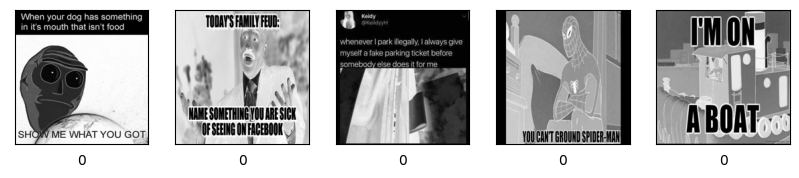

In [7]:
#   Plotting a few images from the training set after pre-processing.

plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i].reshape((200, 200)), cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()

##### **•   Scaling the data:**

"Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance)." **[scikit-learn, 2022]**

I've used sklearn.preprocessing.StandardScaler to standarise the training and testing sets, since many machine learning algorithms perform better when numerical variables are scaled to a standard range.

In [8]:
#   Scaling the training and testing sets.

ss=StandardScaler() #   Creating an instance of the StandardScaler class.
x_train=ss.fit_transform(x_train)   #   Fitting the instance of the StandardScaler class to the training set and transforming it.
x_test=ss.transform(x_test) #   Transforming the testing set.

#### **-   Random Forest Classifier:**

"Random forests or random decision forests is an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time. For classification tasks, the output of the random forest is the class selected by most trees. For regression tasks, the mean or average prediction of the individual trees is returned. Random decision forests correct for decision trees' habit of overfitting to their training set." **[Wikipedia, 2022]**

In [9]:
rf=RandomForestClassifier(n_estimators=100, criterion="entropy", random_state=42)   #   Creating an instance of the RandomForestClassifier class.
rf.fit(x_train, train_labels)   #   Training the model on the training data.

RandomForestClassifier(criterion='entropy', random_state=42)

##### **•   Predicting the labels for the classification model:**

In [10]:
rf_predictions=rf.predict(x_test)   #   Predicting the labels of the testing images.
rf_predictions

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

##### **•   Calculating the accuracy, and displaying the classification report for the classification model:**

In [11]:
rf_score=accuracy_score(test_labels, rf_predictions)    #   Calculating the accuracy of the model.
rf_f1_score=f1_score(test_labels, rf_predictions, average="macro")  #   Calculating the average macro F1-score of the model.
print(classification_report(test_labels, rf_predictions))   #   Printing the classification report of the model.
print("Accuracy: ", rf_score*100, "%")
print("F1-Score (Macro): ", rf_f1_score*100, "%")

              precision    recall  f1-score   support

           0       0.96      0.49      0.65       374
           1       0.65      0.99      0.79       617
           2       1.00      0.54      0.70       164
           3       1.00      0.37      0.54        78
           4       1.00      0.39      0.56        18

    accuracy                           0.73      1251
   macro avg       0.92      0.55      0.65      1251
weighted avg       0.82      0.73      0.71      1251

Accuracy:  73.3013589128697 %
F1-Score (Macro):  64.6443326091765 %


##### **•   Displaying the confusion matrix for the classification model:**

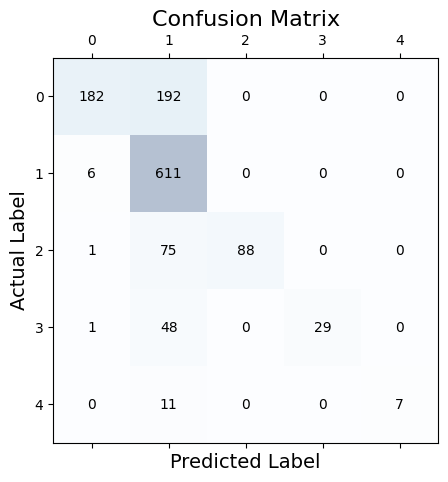

In [12]:
confusion_matrix_rf=confusion_matrix(test_labels, rf_predictions)   #   Creating a confusion matrix for the model.

#   Plotting the confusion matrix.

figure, axis=plt.subplots(figsize=(5, 5))
axis.matshow(confusion_matrix_rf, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_matrix_rf.shape[0]):
    for j in range(confusion_matrix_rf.shape[1]):
        axis.text(x=j, y=i, s=confusion_matrix_rf[i, j], va="center", ha="center")
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("Actual Label", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.show()

#### **-   K-Nearest Neighbours Classifier:**

"The k-nearest neighbors algorithm, also known as KNN or k-NN, is a non-parametric, supervised learning classifier, which uses proximity to make classifications or predictions about the grouping of an individual data point. While it can be used for either regression or classification problems, it is typically used as a classification algorithm, working off the assumption that similar points can be found near one another." **[IBM, 2022]**

I've randomly chosen three nearest neighbours for the classification model. Based on my analysis, the higher the nearest neighbours are, the less accurate the classification model seemingly becomes.

In [13]:
knc=KNeighborsClassifier(n_neighbors=90, weights="distance", metric="minkowski", p=1)   #   Creating an instance of the KNeighborsClassifier class.
knc.fit(x_train, train_labels)  #   Training the model on the training data.

KNeighborsClassifier(n_neighbors=90, p=1, weights='distance')

##### **•   Predicting the labels for the classification model:**

In [14]:
knc_predictions=knc.predict(x_test)   #   Predicting the labels of the testing images.
knc_predictions

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

##### **•   Calculating the accuracy, and displaying the classification report for the classification model:**

In [15]:
knc_score=accuracy_score(test_labels, knc_predictions)    #   Calculating the accuracy of the model.
knc_f1_score=f1_score(test_labels, knc_predictions, average="macro")  #   Calculating the average macro F1-score of the model.
print(classification_report(test_labels, knc_predictions))  #   Printing the classification report of the model.
print("Accuracy: ", knc_score*100, "%")
print("F1-Score (Macro): ", knc_f1_score*100, "%")

              precision    recall  f1-score   support

           0       0.98      0.49      0.65       374
           1       0.65      1.00      0.79       617
           2       1.00      0.53      0.69       164
           3       1.00      0.37      0.54        78
           4       1.00      0.39      0.56        18

    accuracy                           0.74      1251
   macro avg       0.93      0.56      0.65      1251
weighted avg       0.82      0.74      0.72      1251

Accuracy:  73.621103117506 %
F1-Score (Macro):  64.74326535445296 %


##### **•   Displaying the confusion matrix for the classification model:**

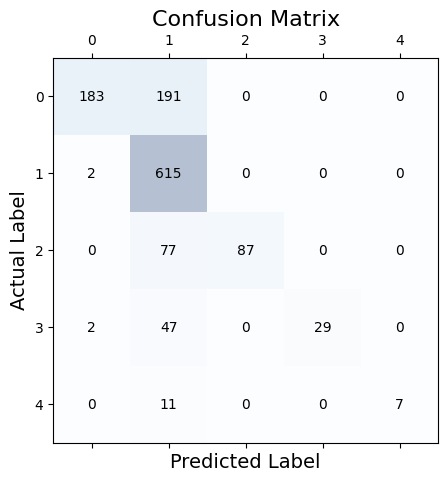

In [16]:
confusion_matrix_knc=confusion_matrix(test_labels, knc_predictions)   #   Creating a confusion matrix for the model.

#   Plotting the confusion matrix.

figure, axis=plt.subplots(figsize=(5, 5))
axis.matshow(confusion_matrix_knc, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_matrix_knc.shape[0]):
    for j in range(confusion_matrix_knc.shape[1]):
        axis.text(x=j, y=i, s=confusion_matrix_knc[i, j], va="center", ha="center")
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("Actual Label", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.show()

#### **-    Extra Trees Classifier:**

"The extra trees algorithm, like the random forests algorithm, creates many decision trees, but the sampling for each tree is random, without replacement. This creates a dataset for each tree with unique samples. A specific number of features, from the total set of features, are also selected randomly for each tree. The most important and unique characteristic of extra trees is the random selection of a splitting value for a feature. Instead of calculating a locally optimal value using Gini or entropy to split the data, the algorithm randomly selects a split value. This makes the trees diversified and uncorrelated." **[ArcGIS Pro, 2022]**

In [17]:
etc=ExtraTreesClassifier(n_estimators=100, random_state=42) #   Creating an instance of the ExtraTreesClassifier class.
etc.fit(x_train, train_labels)  #   Training the model on the training data.

ExtraTreesClassifier(random_state=42)

##### **•   Predicting the labels for the classification model:**

In [18]:
etc_predictions=etc.predict(x_test) #   Predicting the labels of the testing images.
etc_predictions

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

##### **•   Calculating the accuracy, and displaying the classification report for the classification model:**

In [19]:
etc_score=accuracy_score(test_labels, etc_predictions)    #   Calculating the accuracy of the model.
etc_f1_score=f1_score(test_labels, etc_predictions, average="macro")  #   Calculating the average macro F1-score of the model.
print(classification_report(test_labels, etc_predictions))  #   Printing the classification report of the model.
print("Accuracy: ", etc_score*100, "%")
print("F1-Score (Macro): ", etc_f1_score*100, "%")

              precision    recall  f1-score   support

           0       0.95      0.49      0.65       374
           1       0.65      0.99      0.79       617
           2       1.00      0.53      0.69       164
           3       1.00      0.37      0.54        78
           4       1.00      0.39      0.56        18

    accuracy                           0.73      1251
   macro avg       0.92      0.55      0.65      1251
weighted avg       0.81      0.73      0.71      1251

Accuracy:  73.22142286171062 %
F1-Score (Macro):  64.56940593839772 %


##### **•   Displaying the confusion matrix for the classification model:**

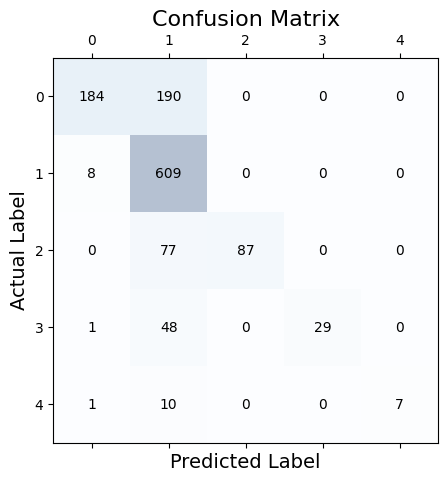

In [20]:
confusion_matrix_etc=confusion_matrix(test_labels, etc_predictions) #   Creating a confusion matrix for the model.

#   Plotting the confusion matrix.

figure, axis=plt.subplots(figsize=(5, 5))
axis.matshow(confusion_matrix_etc, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_matrix_etc.shape[0]):
    for j in range(confusion_matrix_etc.shape[1]):
        axis.text(x=j, y=i, s=confusion_matrix_etc[i, j], va="center", ha="center")
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("Actual Label", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.show()

##### **•   Testing the most accurate classification model against a custom image (meme):**

Now that I've implemented and trained all three models successfully, I can test the most accurate one out of all, which is the K-Nearest Neighbours model, against a custom image (meme) to see if the predicted result is correct or not. In this case, the predicted result seems to be correct.

Image:


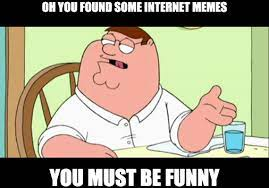

In [21]:
image_path="test_images\download.jpg"   #   Path of the image to be tested.
image=Image.open(image_path)    #   Opening the image.
print("Image:")
image

In [22]:
image=image.convert("L")    #   Converting the image to grayscale.
image=image.resize((200, 200))  #   Resizing the image to (200 x 200) pixels.
image=np.array(image)   #   Converting the image to a NumPy.Array.
image=np.array(image)/255.0 #   Normalising the image.
nx, ny=image.shape  #   Retrieving the dimensions of the image.
image=image.reshape((1, nx*ny)) #   Reshaping the image to a one-dimensional array.
classes=["neutral", "positive", "very_positive", "negative", "very_negative"]   #   Defining a list of all the classes.
answer=knc.predict(image)  #   Predicting the label of the image.
print("Predicted:", classes[answer[0]])

Predicted: positive


### **‣ Text Classification:**

Now that I'm finished with the image classification, I've trained and tested another three noteworthy machine learning classification models for text classification, namely Stochastic Gradient Descent Classifier, Multinomial Naïve Bayes Classifier, and Logistc Regression, against the training and testing sets for the image text information to find the most accurate one.

##### **•   Reading the data (again):**

In [23]:
dataframe=pd.read_csv("labels.csv") #   Reading the data from the specified CSV (.csv) file.
dataframe=dataframe.drop(dataframe.columns[0], axis=1)  #   Dropping the first column of the dataframe.
dataframe["overall_sentiment"]=dataframe["overall_sentiment"].map({"neutral":0, "positive":1, "very_positive":2, "negative":3, "very_negative":4})    #   Assigning numerical values to the image sentiments.
dataframe=dataframe.sort_values(by=["overall_sentiment"], ascending=True)
dataframe=dataframe.reset_index(drop=True)  #   Resetting the index of the pandas.DataFrame.
dataframe

,image_name,text_ocr,text_corrected,overall_sentiment
0,image_1311.jpg,THAT MOMENT YOU REALIZE USE THIS WAS A REALLY ...,THAT MOMENT YOU REALIZE USE THIS WAS A REALLY ...,0
1,image_1664.jpg,THE FACE YOU MAKE WHEN YOU MEET HER EX PUUSLIW...,THE FACE YOU MAKE WHEN YOU MEET HER EX PUUSLIW...,0
2,image_5509.jpg,Me in 2011 small issues offhandedly dismissed ...,Me in 2011 small issues offhandedly dismissed ...,0
3,image_1666.jpg,WEALTHY KNIGHT THAT COULD HAVE ANY WOMAN? FUCK...,WEALTHY KNIGHT THAT COULD HAVE ANY WOMAN? FUCK...,0
4,image_1669.jpg,WHAT YOU THINK YOU LOOK LIKE FLIRTING WITH YOU...,WHAT YOU THINK YOU LOOK LIKE FLIRTING WITH YOU...,0
...,...,...,...,...
6987,image_4076.jpg,YOU GET TO EAT FOOD EVERYDAY?! quickmeme.com,YOU GET TO EAT FOOD EVERYDAY?! quickmeme.com,4
6988,image_5871.jpg,"DATHI WHAT IS WITH ""HER NECK ANYWAY? imgflip.com","DATHI WHAT IS WITH ""HER NECK ANYWAY? imgflip.com",4
6989,image_3622.jpg,DONT TREAT WOMEN LIKE OBJECTS OBJECTS ARE USEF...,DONT TREAT WOMEN LIKE OBJECTS OBJECTS ARE USEF...,4
6990,image_5451.jpeg,THIS IS THE I'M WHITE,"THIS IS THE I'M WHITE BUT MY KIDS WONT BE""HAIRDO",4


##### **•   Balancing the imbalanced classes:**

In [24]:
#   Separating the majority and minority classes.

dataframe_majority=dataframe[dataframe["overall_sentiment"]==1]
dataframe_minority=dataframe[dataframe["overall_sentiment"]!=1]

dataframe_minority_upsampled=resample(dataframe_minority, replace=True, n_samples=len(dataframe_majority), random_state=42) #   Resampling the minority class with replacement.
dataframe_upsampled=pd.concat([dataframe_majority, dataframe_minority_upsampled])   #   Concatenating the majority and minority class pandas.DataFrames.
dataframe_upsampled=dataframe_upsampled.sort_values(by=["overall_sentiment"], ascending=True)   #   Sorting the pandas.DataFrame by the overall sentiment.
dataframe_upsampled=dataframe_upsampled.reset_index(drop=True)  #   Resetting the index of the pandas.DataFrame.
dataframe_upsampled["overall_sentiment"].value_counts() #   Finding the frequencies of each sentiment in the pandas.DataFrame.

1    3127
0    1784
2     837
3     398
4     108
Name: overall_sentiment, dtype: int64

##### **•   Applying one-hot encoding to the image sentiments:**

Since scikit-learn expects only numerical values, I've first converted the necessary raw text (string) data into numerical/dummy variables. Of course, it's not practical to convert the extracted (corrected) text from the images into categorical/dummy variables as well, so I've applied one-hot encoding on the image sentiments only.

In [25]:
ohe_dataframe=pd.get_dummies(dataframe_upsampled, columns=["overall_sentiment"])    #   Converting all the categorical variables into numerical/dummy variables.
ohe_dataframe

,image_name,text_ocr,text_corrected,overall_sentiment_0,overall_sentiment_1,overall_sentiment_2,overall_sentiment_3,overall_sentiment_4
0,image_6455.jpg,I just want someone to look at me the way Bill...,I just want someone to look at me the way Bill...,1,0,0,0,0
1,image_4616.png,Deadpool had a daughter named Eleanor,Deadpool had a daughter named Eleanor but Dea...,1,0,0,0,0
2,image_5382.png,HOW I ROLL OUT OF BED IN THE MORNING,HOW I ROLL OUT OF BED IN THE MORNING,1,0,0,0,0
3,image_6198.png,"<html><head><meta content=""text/html; charset=...",HE DOESN'T ASK GOOGLE GOOGLE ASKS HIM! CHUCK....,1,0,0,0,0
4,image_4473.png,WHEN CHUCK NORRIS LEFT FOR COLLEGE HE TOLD HIS...,WHEN CHUCK NORRIS LEFT FOR COLLEGE HE TOLD HIS...,1,0,0,0,0
...,...,...,...,...,...,...,...,...
6249,image_5298.jpg,First,"First I was like ""Hodor..."" But then I was a...",0,0,0,0,1
6250,image_2750.jpeg,When you're about to be drafted into the milit...,When you're about to be drafted into the milit...,0,0,0,0,1
6251,image_3619.jpg,When you unplug your dying grandpa to charge y...,When you unplug your dying grandpa to charge y...,0,0,0,0,1
6252,image_1995.png,HILLARY GETS CAUGHT IN NON-STOP CORRUPTION SCA...,HILLARY GETS CAUGHT IN NON-STOP CORRUPTION SCA...,0,0,0,0,1


##### **•   Pre-processing the data:**

After the categorical variables have been converted to numerical/dummy variables, I've used sklearn.feature_extraction.text.TfidfVectorizer to convert the raw text into a matrix of word counts. Additionally, it can also filter out any stop-words, which can make the machine learning classification models more accurate. I've then split the text data into training and testing sets using the sklearn.model_selection.train_test_split function. Since classification metrics in scikit-learn can't handle a combination of multilabel-indicator and multiclass targets (one-hot encoded vectors), I've also converted the training and testing sets into one-dimensional arrays before being trained by any machine learning classification model(s).

In [26]:
vectorizer=TfidfVectorizer(max_features=1000, stop_words=stopwords.words("english"), ngram_range=(1, 2))    #   Creating an instance of the TfidfVectorizer class.
x=vectorizer.fit_transform(ohe_dataframe["text_corrected"].values.astype("U"))    #   Creating a bag of words model.
y=ohe_dataframe[["overall_sentiment_0", "overall_sentiment_1", "overall_sentiment_2", "overall_sentiment_3", "overall_sentiment_4"]].values
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.2, random_state=42)    #   Splitting the data into training and testing data.

#   Converting the one-hot encoded labels into a one-dimensional array.

y_train=np.argmax(y_train, axis=1)
y_test=np.argmax(y_test, axis=1)

#   Converting the sparse matrices into dense matrices.

x_train=x_train.toarray()
x_test=x_test.toarray()

#### **-    Stochastic Gradient Descent Classifier:**

"Stochastic gradient descent (often abbreviated SGD) is an iterative method for optimizing an objective function with suitable smoothness properties (e.g. differentiable or subdifferentiable). It can be regarded as a stochastic approximation of gradient descent optimization, since it replaces the actual gradient (calculated from the entire data set) by an estimate thereof (calculated from a randomly selected subset of the data). Especially in high-dimensional optimization problems this reduces the very high computational burden, achieving faster iterations in trade for a lower convergence rate." **[Wikipedia, 2022]**

In [27]:
sgd=SGDClassifier(loss="perceptron", penalty="l2", max_iter=100000, random_state=42, n_jobs=-1)    #   Creating an instance of the SGDClassifier class.
sgd.fit(x_train, y_train)   #   Training the model.

SGDClassifier(loss='perceptron', max_iter=100000, n_jobs=-1, random_state=42)

##### **•   Predicting the labels for the classification model:**

In [28]:
sgd_predictions=sgd.predict(x_test)   #   Predicting the labels of the testing data.
sgd_predictions

array([1, 1, 1, ..., 1, 1, 0], dtype=int64)

##### **•   Calculating the accuracy, and displaying the classification report for the classification model:**

In [29]:
sgd_score=accuracy_score(y_test, sgd_predictions)    #   Calculating the accuracy of the model.
sgd_f1_score=f1_score(y_test, sgd_predictions, average="weighted")    #   Calculating the average weighted F1-score of the model.
print(classification_report(y_test, sgd_predictions))   #   Printing the classification report of the model.
print("Accuracy: ", sgd_score*100, "%")
print("F1-Score (Weighted): ", sgd_f1_score*100, "%")

              precision    recall  f1-score   support

           0       0.42      0.37      0.39       374
           1       0.53      0.72      0.61       617
           2       0.41      0.18      0.25       164
           3       0.47      0.09      0.15        78
           4       0.43      0.17      0.24        18

    accuracy                           0.50      1251
   macro avg       0.45      0.30      0.33      1251
weighted avg       0.48      0.50      0.46      1251

Accuracy:  49.5603517186251 %
F1-Score (Weighted):  46.45273990562543 %


##### **•   Displaying the confusion matrix for the classification model:**

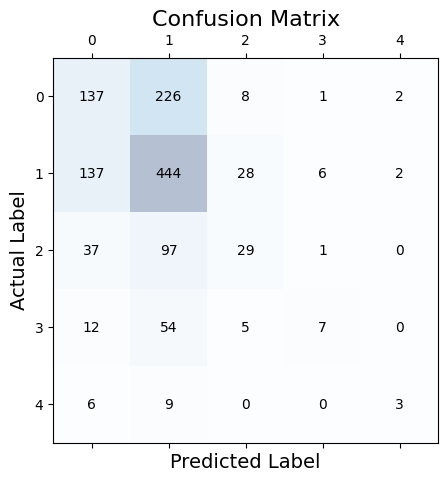

In [30]:
confusion_matrix_sgd=confusion_matrix(y_test, sgd_predictions) #   Creating a confusion matrix for the model.

#   Plotting the confusion matrix.

figure, axis=plt.subplots(figsize=(5, 5))
axis.matshow(confusion_matrix_sgd, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_matrix_sgd.shape[0]):
    for j in range(confusion_matrix_sgd.shape[1]):
        axis.text(x=j, y=i, s=confusion_matrix_sgd[i, j], va="center", ha="center")
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("Actual Label", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.show()

#### **-    Multinomial Naïve Bayes Classifier:**

"The Multinomial Naïve Bayes algorithm is a Bayesian learning approach popular in Natural Language Processing (NLP). The program guesses the tag of a text, such as an email or a newspaper story, using the Bayes theorem. It calculates each tag's likelihood for a given sample and outputs the tag with the greatest chance." **[upGrad, 2023]**

In [31]:
mnb=MultinomialNB() #   Creating an instance of the MultinomialNB class.
mnb.fit(x_train, y_train)   #   Training the model on the training data.

MultinomialNB()

##### **•   Predicting the labels for the classification model:**

In [32]:
mnb_predictions=mnb.predict(x_test)   #   Predicting the labels of the testing data.
mnb_predictions

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

##### **•   Calculating the accuracy, and displaying the classification report for the classification model:**

In [33]:
mnb_score=accuracy_score(y_test, mnb_predictions)   #   Calculating the accuracy of the model.
mnb_f1_score=f1_score(y_test, mnb_predictions, average="weighted")   #   Calculating the average weighted F1-score of the model.
print(classification_report(y_test, mnb_predictions, zero_division=1))  #   Printing the classification report of the model.
print("Accuracy: ", mnb_score*100, "%")
print("F1-Score (Weighted): ", mnb_f1_score*100, "%")

              precision    recall  f1-score   support

           0       0.47      0.18      0.26       374
           1       0.51      0.91      0.66       617
           2       0.50      0.02      0.05       164
           3       1.00      0.00      0.00        78
           4       1.00      0.00      0.00        18

    accuracy                           0.51      1251
   macro avg       0.70      0.22      0.19      1251
weighted avg       0.54      0.51      0.41      1251

Accuracy:  50.83932853717026 %
F1-Score (Weighted):  40.887047738187924 %


##### **•   Displaying the confusion matrix for the classification model:**

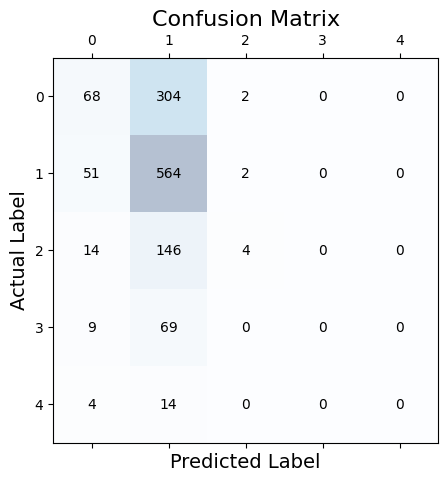

In [34]:
confusion_matrix_mnb=confusion_matrix(y_test, mnb_predictions)   #   Creating a confusion matrix for the model.

#   Plotting the confusion matrix.

figure, axis=plt.subplots(figsize=(5, 5))
axis.matshow(confusion_matrix_mnb, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_matrix_mnb.shape[0]):
    for j in range(confusion_matrix_mnb.shape[1]):
        axis.text(x=j, y=i, s=confusion_matrix_mnb[i, j], va="center", ha="center")
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("Actual Label", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.show()

#### **-    Logistic Regression:**

"Logistic regression estimates the probability of an event occurring, such as voted or didn’t vote, based on a given dataset of independent variables. Since the outcome is a probability, the dependent variable is bounded between zero and one. In logistic regression, a logit transformation is applied on the odds — that is, the probability of success divided by the probability of failure." **[IBM, 2022]**

In [35]:
lr=LogisticRegression(solver="liblinear", max_iter=10000, class_weight="balanced", penalty="l2", dual=True) #   Creating an instance of the LogisticRegression class.
lr.fit(x_train, y_train)    #   Training the model on the training data.

LogisticRegression(class_weight='balanced', dual=True, max_iter=10000,
                   solver='liblinear')

##### **•   Predicting the labels for the classification model:**

In [36]:
lr_predictions=lr.predict(x_test)   #   Predicting the labels of the testing data.
lr_predictions

array([2, 3, 1, ..., 1, 1, 2], dtype=int64)

##### **•   Calculating the accuracy, and displaying the classification report for the classification model:**

In [37]:
lr_score=accuracy_score(y_test, lr_predictions)   #   Calculating the accuracy of the model.
lr_f1_score=f1_score(y_test, lr_predictions, average="weighted")   #   Calculating the average weighted F1-score of the model.
print(classification_report(y_test, lr_predictions))    #   Printing the classification report of the model.
print("Accuracy: ", lr_score*100, "%")
print("F1-Score (Weighted): ", lr_f1_score*100, "%")

              precision    recall  f1-score   support

           0       0.46      0.33      0.38       374
           1       0.53      0.57      0.55       617
           2       0.30      0.32      0.31       164
           3       0.18      0.22      0.20        78
           4       0.16      0.44      0.23        18

    accuracy                           0.44      1251
   macro avg       0.32      0.38      0.33      1251
weighted avg       0.45      0.44      0.44      1251

Accuracy:  44.04476418864908 %
F1-Score (Weighted):  44.045748357289824 %


##### **•   Displaying the confusion matrix for the classification model:**

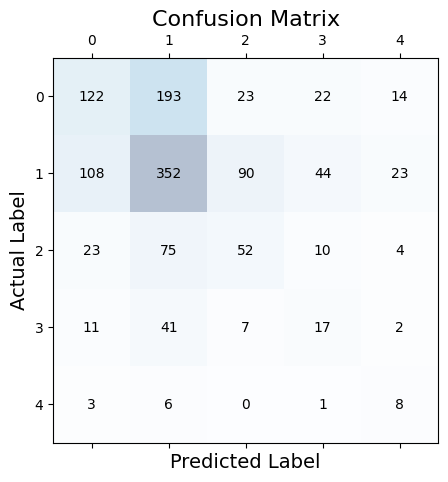

In [38]:
confusion_matrix_lr=confusion_matrix(y_test, lr_predictions)   #   Creating a confusion matrix for the model.

#   Plotting the confusion matrix.

figure, axis=plt.subplots(figsize=(5, 5))
axis.matshow(confusion_matrix_lr, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_matrix_lr.shape[0]):
    for j in range(confusion_matrix_lr.shape[1]):
        axis.text(x=j, y=i, s=confusion_matrix_lr[i, j], va="center", ha="center")
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("Actual Label", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.show()

##### **•   Calculating the average F1-score of all the analysed classification models:**

In [39]:
#   Calculating the average F1-score of all the analyzed classification models.

f1_scores=[rf_f1_score, knc_f1_score, etc_f1_score, sgd_f1_score, mnb_f1_score, lr_f1_score]
print("Average F1-Score: ", sum(f1_scores)/len(f1_scores)*100, "%")

Average F1-Score:  54.22375665052173 %


##### **•   Testing the most accurate classification model against text extracted from a custom image (meme):**

Now that I've implemented and trained all three text classification models successfully, I can test the most accurate one out of all, which is the Multinomial Naïve Bayes model, against text extracted from a custom image (meme) to see if the predicted result is correct or not. In this case, the predicted result seems to be correct.

Image:


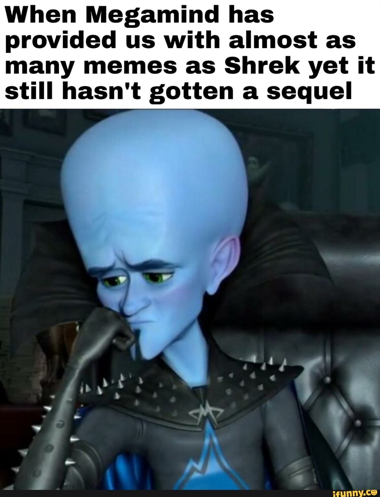

In [40]:
image_path="test_images\meme.jpg"   #   Path of the image to be tested.
image=Image.open(image_path)    #   Opening the image.
image=image.resize((380, 497))  #   Resizing the image.
print("Image:")
image

In [41]:
pytesseract.pytesseract.tesseract_cmd=r"C:\Program Files\Tesseract-OCR\tesseract.exe"   #   Path of the Tesseract executable.
text=pytesseract.image_to_string(image) #   Extracting the text from the image.
print("Text:")
print(text)

Text:
When Megamind has
provided us with almost as

many memes as Shrek yet it
still hasn't gotten a sequel

Ae



In [42]:
def clean_text(text):
    text=text.lower()   #   Converting the text to lowercase.
    text=re.sub(r"[^a-z0-9]", " ", text)    #   Removing all the characters except alphabets and numbers.
    text=re.sub(r"\s+", " ", text)  #   Removing all the extra spaces.
    return text

text=clean_text(text)   #   Cleaning the text.
text=vectorizer.transform([text])    #   Transforming the text into a vector.
classes=["neutral", "positive", "very_positive", "negative", "very_negative"]   #   Defining a list of all the classes.
text=mnb.predict(text)  #   Predicting the label of the text.
print("Predicted: ", classes[text[0]])

Predicted:  positive


### **‣ Comparison (Accuracy):**

##### **•   Plotting the accuracies of all six analysed machine learning classification models:**

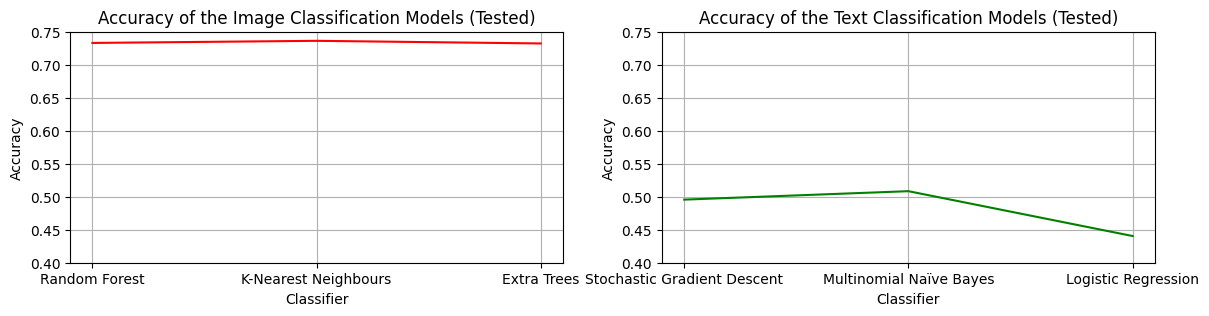

In [43]:
#   Creating a subplot for the figures.

figure, axes=plt.subplots(1, 2, figsize=(14, 3))

#   Plotting the accuracy of the image and text classification models.

axes[0].plot(["Random Forest", "K-Nearest Neighbours", "Extra Trees"], [rf_score, knc_score, etc_score], color="red")
axes[1].plot(["Stochastic Gradient Descent", "Multinomial Naïve Bayes", "Logistic Regression"], [sgd_score, mnb_score, lr_score], color="green")

#   Setting the titles of the figures.

axes[0].set_title("Accuracy of the Image Classification Models (Tested)")
axes[1].set_title("Accuracy of the Text Classification Models (Tested)")

#   Setting the labels of the axes.

axes[0].set_xlabel("Classifier")
axes[1].set_xlabel("Classifier")
axes[0].set_ylabel("Accuracy")
axes[1].set_ylabel("Accuracy")

#   Setting the tick labels of the axes.

axes[0].set_xticks(["Random Forest", "K-Nearest Neighbours", "Extra Trees"])
axes[1].set_xticks(["Stochastic Gradient Descent", "Multinomial Naïve Bayes", "Logistic Regression"])
axes[0].set_yticks(np.arange(0.4, 0.8, 0.05))
axes[1].set_yticks(np.arange(0.4, 0.8, 0.05))

#   Adding a grid to the figures.

axes[0].grid()
axes[1].grid()

plt.show()

### **‣   Conclusion:**

Based on the accuracies all six analysed machine learning classification models, it's clear that the K-Nearest Neighbours model is the most accurate one when it comes to analysing the sentiment(s) behind images (memes), with an accuracy of approximately **73.62%**. Of course, this isn't highly accurate either, since machine learning algorithms generally perform poorly. 

It's also worth noting that, compared to the image classification models, the text classification models for significantly more inaccurate, which could be due to the imbalance in the classes of the pandas.DataFrame. While balancing the classes increased the accuracy significantly in the case of image classification, there are still some discrepancies in the analysed text classification models that are causing some classes to remain unaccounted for. However, I've still managed to achieve relatively decent accuracies with the text classification models, with the most accurate being the Multinomial Naïve Bayes model, having an accuracy of approximately **50.84%**.

Lastly, for the image classification models, it can be seen that I've relied more on the average weighted F1-score, while in the case of the text classification models, I've relied more on the average weighted F1-score. This is due to the evident imbalance in the classes of the pandas.DataFrame. For image classification, this imbalance was successfully resolved through the up-sampling method, but that wasn't the case for text classification. As such, the average weighted F1-score is preferred more for cases where the classes are known to be imbalanced, since in this case, each class contribution to the average is weighted by the relative number of examples available for it.

**Read:** https://datascience.stackexchange.com/a/24051

##### **•   Exporting all the machine learning classification models:**

In [44]:
#   Exporting all the machine learning classification models into separate pickle (.pkl) files.

pickle.dump(rf, open("rf_model.pkl", "wb"))
pickle.dump(knc, open("knc_model.pkl", "wb"))
pickle.dump(etc, open("etc_model.pkl", "wb"))
pickle.dump(sgd, open("sgd_model.pkl", "wb"))
pickle.dump(mnb, open("mnb_model.pkl", "wb"))
pickle.dump(lr, open("lr_model.pkl", "wb"))
pickle.dump(vectorizer, open("vectorizer.pkl", "wb"))